# 逻辑回归
  
回归，是指假设一个模型，设定一些参数，计算合适的参数以拟合逼近现有数据。

#### Linear Regression
$$h_\theta(x) = θ^Tx+θ_0$$
#### Logistic Regression
$$h_\theta(x) = g(θ^Tx+θ_0) = P(y=1|x,θ)$$
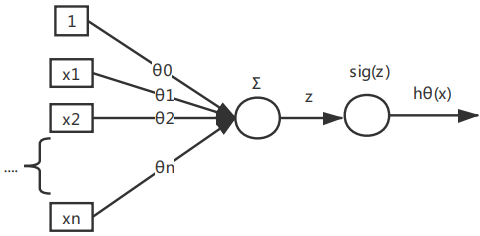


线性回归用一条直线模型去拟合数据，用来确定两种或两种以上变量间相互依赖的定量关系

逻辑回归计算样本属于某个标签的概率，构建一个分类边界，用来对数据进行二分类或者多分类。

上次实验我们用梯度下降训练了一个线性回归模型，这次我们实现一个逻辑回归模型来进行二分类的收入判断任务。

##### 注意事项：
本实验可能用到的函数：`np.mean`, `np.std`, `np.add`, `np.sum`, `np.mutual`, `np.dot`

本实验大部分变量为numpy array的数据类型，在计算时尽量化为numpy array类型进行计算

### 任务一：读取和预处理数据

第一步导入数据。压缩包中的train.csv中存储了原始数据，每人拥有年龄，工作类型等14个维度，共32561个样本。最后一个维度为本次实验的label，即收入是否大于50k。

做机器学习应用的时候很多时间是花费在特征处理上，我们注意到原始数据存在许多维度为非数字的数据，是不能直接用于构建模型的。我们可以通过离散化，把一个维度扩展到多个维度。如教育程度：（小学，初中，高中+）可以被扩展到如下三个维度：小学学历（是，否），初中学历（是，否），高中学历以上（是，否）。

经上述处理后的数据存储在X_train文件中，每个样本的维度被扩展到了106维，本实验直接使用X_train的数据构建模型。

In [1]:
import numpy as np 
from matplotlib import pyplot as plt

def getdata(X_train,Y_train):
    X = np.genfromtxt(X_train,delimiter=',',skip_header=1) #32561个样本*106个特征
    Y = np.genfromtxt(Y_train,delimiter=',',skip_header=1) #32561个label
    return X,Y

def shuffle(X,Y):
    #打乱X,Y,避免数据存在初始的排序，影响训练效果
    randomize = np.arange(len(X)) #不同的库用的不太一样，返回的对象也不太一样。python自带的range()不支持numpy的shuffle
    np.random.shuffle(randomize)
    return (X[randomize], Y[randomize]) #ndarray的参数是数组时，返回一个依参数排序后的数组    

def train_test_split(X, Y, test_size=0.1314):
    #按一个比例分出一部分验证集
    train_len = int(round(len(X)*(1-test_size)))
    return X[0:train_len], Y[0:train_len], X[train_len:None], Y[train_len:None]

X,Y = getdata('X_train','Y_train')
X, Y, X_test, Y_test = train_test_split(X, Y)

X.shape 

(28282, 106)

### 任务二：数据归一化

归一化把每个特征的数据映射到0到1之间，消除指标之间的量纲影响，同时可以避免某些特征对模型预测结果的影响过大。

常用的归一化方法有两种：

一是利用最大最小值(min-max 归一化)；

二是利用平均值方差(z-score 0均值标准化)。

一般来说0均值标准化调整了数据的分布，使之更易于训练。

In [7]:
def normalization(X):
    """将X中的数据映射到0-1之间
    参数：
        X:数据
    返回：
        归一化之后的X
    注意：
        测试在只归一化0,1,3,4,5,7,10,12,25,26,27,28列特征时，效果会比较好
        具体原因可探讨
    """    
    ### START THE CODE ###

    for i in [0,1,3,4,5,7,10,12,25,26,27,28]:
        X_mean=np.mean(X[:,i],axis=0)
        X_std=np.std(X[:,i],axis=0)
        X[:,i]=(X[:,i]-X_mean)/X_std
    
    ### END THE CODE ###
    
    return X

X = normalization(X)
X_test = normalization(X_test)
X[:1]

array([[ 0.02997349, -1.06586717,  1.        ,  0.14215522, -0.21607549,
        -0.03383413,  0.        , -0.26256323,  0.        ,  0.        ,
        -0.1885562 ,  0.        ,  4.9041296 ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
        -0.11434365, -0.69111392, -0.23540742, -0.03992059,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0. 

### 任务三：完成sigmoid函数

sigmoid funtion函数原指曲线是 “S”形的函数，logistic function则指满足某个公式形式的一系列函数。
在机器学习中，其一般特指以下函数（standard logistic function）：
$$f(x) = \frac{1}{1+e^{-z}}$$

In [9]:
def sigmoid(z):
    """
    参数：
        z
    返回：
        sigmoid(z)
    """   
    ### START THE CODE ###
    
    s=1/(1+np.exp(-z))
    
    ### END THE CODE ###
    
    return np.clip(s, 1e-6, 1-1e-6)
    #clip:重要的处理，将超出范围的值强制置为边界值，避免y_pred为0，从而导致下面交叉熵损失无法计算
    #aeN: a*10的N次方
    
sigmoid(0.5)

0.6224593312018546

### 任务四：完成交叉熵损失函数
$$J(\theta)=-\frac{1}{m}\sum_1^m[y^ilog(h_\theta(x^i))+(1-y^i)log(1-h_\theta(x^i))]$$
损失函数用于评价模型预测同实际情况的差异，越小说明预测越准确。

概念上, 损失函数针对单个样本，代价函数针对总体。但作为优化目标时二者无不同。

交叉熵数学意义上衡量的是两个概率分布间的差异，本实验以交叉熵损失为优化目标函数。

In [10]:
def cost(y_pred, y_label, m):
    """代价函数，这里计算的是所有样本损失函数的和
    参数：
        y_pred：模型预测的值
        y_label：数据实际标签的值
        m：数据的样本数
    返回：
        cst: 预测值同标签值之间的代价
    """   
    ### START THE CODE ###
    
    cst=-np.sum(y_label*np.log(y_pred)+(1-y_label)*np.log(1-y_pred))/m
    
    ### END THE CODE ###
    
    return cst

cost(0.4,0.6,1) #numpy的log以e为底

0.7541046886308893

### 任务五：构建逻辑回归模型

$$\hat y=sig(θ_1*x_1+θ_2*x_2+...+θ_n*x_n+θ_0)$$

接下来先设置模型所需要的参数，可以自己修改观察对模型的影响。

对于样本的偏置θ0，有两种处理方法：
一种是作为一个维度添加到array θ上，相应样本也要添加一个值全为1的维度；

一种是单独拿出来更新，在梯度下降时分别处理。

本实验采取的是第二种方法。

最后完成模型所需的两个基本函数predict，和accuracy。

In [18]:
def predict(X, theta, theta_0):
    """预测
    参数：
        X：样本特征
        theta：权重参数 
        theta_0: 偏置参数
    返回：
        Y_pred: 样本的预测值 0~1
    """      
    ### START THE CODE ###
    
    theta=np.array(theta)
    Y_pred=sigmoid(np.dot(X,theta)+theta_0)
    
    ### END THE CODE ###
    
    return Y_pred

def accuracy(Y_hat, Y_label):
    """准确率
    参数：
        Y_hat：样本最终分类 0 or 1
        Y_label：样本标签
    返回：
        acc: 分类准确率
    """      
    ### START THE CODE ###
    
    acc=np.sum(Y_hat==Y_label)/len(Y_label)
    
    ### END THE CODE ###
    
    return acc

predict([0.4,0.8],[0.1,0.2],[0.15])

array([0.58661758])

### 任务六：用随机梯度下降算法训练模型

全样本的梯度下降，在样本过大时，更新一次参数会需要巨大计算量。我们可以每次从中随机取出一定大小的样本，进行小批量随机梯度下降。
随机取样部分已完成，只需根据样本梯度下降更新参数即可。

根据我们的优化目标（默认为交叉熵），对损失函数求导，得到梯度计算公式为：
$$(h_\theta(x^i)-y)x^i$$
(推导见ppt)

θ，θ0更新时分别处理

In [19]:
def gradient_descent(x_bt, y_bt, theta, theta_0, learning_rate):
    """用每次取出的一个batch的数据训练模型
    参数：
        x_bt:本次更新所用样本
        y_bt:本次更新样本的标签
        theta,theta_0：模型参数
    返回:
        theta:更新后的theta
        theta_0:更新后的theta_0
    过程：
        用theta,theta_0进行一次预测
        计算预测误差
        计算theta, theta_0各自的梯度，取均值
        用梯度更新theta_0和theta
    """ 
    ### START THE CODE ###

    pred_error=predict(x_bt,theta,theta_0)-y_bt
    theta_grad=np.mean(np.dot(pred_error,x_bt),axis=0)
    theta_0_grad=np.mean(pred_error)
    theta=theta-learning_rate*theta_grad
    theta_0=theta_0-learning_rate*theta_0_grad

    ### END THE CODE ###
    
    return theta,theta_0

gradient_descent(np.array([[1]]),np.array([1]),np.array([0.2]),np.array([0.1]),0.02)

(array([0.20851115]), array([0.10851115]))

In [20]:
#模型的基本参数：
theta = np.zeros(X.shape[1],) #106个权重参数，初值全为0
theta_0 = np.zeros(1,) #1个偏置参数，初值为0

#训练参数
max_iter = 80 #迭代次数
batch_size = 32 #随机梯度下降中每次取样个数
learning_rate = 0.02 #学习率，可以尝试不同的学习率，如0.2、0.002、0.0002
num_train = len(Y)
num_test = len(Y_test)


def train(X, Y, theta, theta_0, max_iter, batch_size, learning_rate):
    #用于记录训练中损失和准确率的变化
    train_cost = []
    test_cost = []
    train_acc = []
    test_acc = []

    for epoch in range(max_iter):
        X, Y = shuffle(X, Y) #随机打乱各行数据，这样参数不易陷入局部最优，模型能够更容易达到收敛。 
        for i in range(int(np.floor(len(Y)/batch_size))): #每个batch更新一次
            x_bt = X[i*batch_size:(i+1)*batch_size] #32个样本*106维
            y_bt = Y[i*batch_size:(i+1)*batch_size] #32个label
            
            #每个batch的样本更新参数theta,theta_0
            theta,theta_0 = gradient_descent(x_bt,y_bt,theta,theta_0,learning_rate)
        
        #记录每个epoch更新后，训练集上损失的变化和准确率的变化
        Y_pred = predict(X, theta, theta_0)
        Y_hat = np.round(Y_pred)
        train_acc.append(accuracy(Y_hat, Y))
        train_cost.append(cost(Y_pred, Y, num_train))
        #记录每个epoch更新后，测试集上损失的变化和准确率的变化
        Y_test_pred = predict(X_test, theta, theta_0)
        Y_test_hat = np.round(Y_test_pred)
        test_acc.append(accuracy(Y_test_hat, Y_test))
        test_cost.append(cost(Y_test_pred, Y_test, num_test))
        
    return train_cost,test_cost,train_acc,test_acc
        
train_cost,test_cost,train_acc,test_acc = train(X, Y, theta, theta_0, max_iter, batch_size, learning_rate)      
len(train_cost)

80

### 任务七：观察模型在训练集和验证集上的表现

用matplotlib(plt)里的方法生成图表，观察随着迭代进行，模型损失和准确率的变化

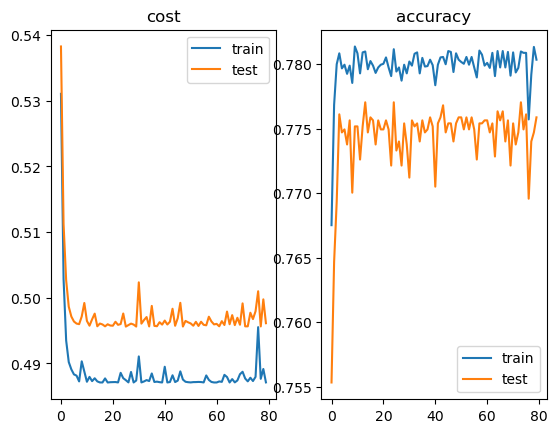

In [21]:
#子图1：损失
p1 = plt.subplot(121)
p1.plot(train_cost)
p1.plot(test_cost)
p1.legend(['train', 'test'])
p1.set_title("cost")

#子图2，准确率
p2 = plt.subplot(122)
p2.plot(train_acc)
p2.plot(test_acc)
p2.legend(['train', 'test'])
p2.set_title("accuracy")
plt.show()

### 样例输出：
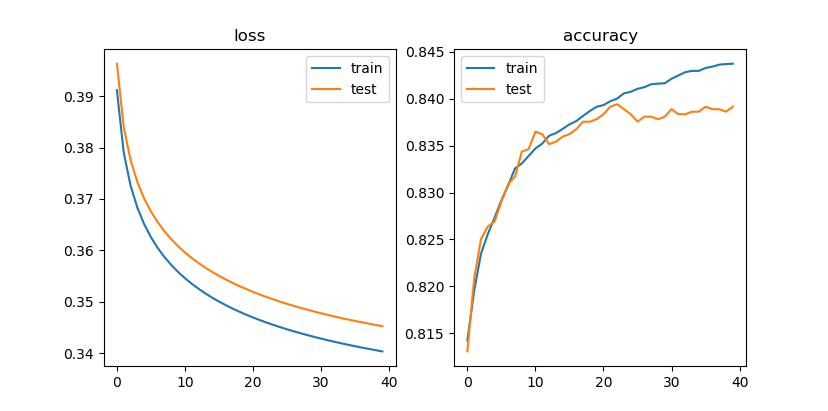

由于训练过程有一定随机性，训练结果可能存在不同